In [ ]:
%matplotlib inline

### Atenção: Rode esta linha apenas se estiver usando o Google Colab

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [1]:
import torch
from torch import nn
from torch import optim
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision import datasets

### O código da célula abaixo contém funções para efetuar a carga dos dados, treinamento teste dos modelos

In [2]:
def get_loaders(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(
            root='../data', 
            train=True, 
            download=True,
            transform=transform,
        ),
        batch_size=batch_size, 
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(
            root='../data', 
            train=False, 
            download=True,
            transform=transform,
        ),
        batch_size=batch_size, 
        shuffle=True
    )
    return train_loader, test_loader

def train_epoch(
        model, 
        device, 
        train_loader, 
        optimizer, 
        criterion, 
        epoch, 
        log_interval
    ):
    model.train()
    history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(
        model, 
        device, 
        criterion, 
        test_loader
    ):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy


def train(
        model,
        train_loader,
        test_loader,
        device,
        lr,
        nb_epochs=3,
        log_interval=100,
    ):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)

    for epoch in range(1, nb_epochs + 1):
        print('\n* * * Training * * *')
        train_epoch(
            model=model, 
            device=device, 
            train_loader=train_loader, 
            optimizer=optimizer, 
            criterion=criterion, 
            epoch=epoch, 
            log_interval=log_interval
        )
        print('\n* * * Evaluating * * *')
        acc = test(model, device, criterion, test_loader)        
    
    return acc

def check_input(model, device):
    dummy_data = torch.zeros(5, 1, 28, 28).to(device)
    dummy_pred = model(dummy_data)        
    assert dummy_pred.shape == (5, 10), '\nOutput expected: (batch_size, 10) \nOutput found   : {}'.format(dummy_pred.shape)
    print('Passed')
    return dummy_pred

### Hyper-parâmetros que você pode definir

In [3]:
batch_size = 16
device_name = 'cpu'
nb_epochs = 3
log_interval = 500
lr = 1e-3

In [4]:
device = torch.device(device_name)

### Conferência dos dados

In [5]:
train_loader, test_loader = get_loaders(batch_size=batch_size)

Processing...
Done!


In [6]:
print(
    'Train size: ', 
    train_loader.dataset.train_data.shape, 
    train_loader.dataset.train_labels.shape
)
print(
    'Test size : ', 
    test_loader.dataset.test_data.shape, 
    test_loader.dataset.test_labels.shape
)

Train size:  torch.Size([60000, 28, 28]) torch.Size([60000])
Test size :  torch.Size([10000, 28, 28]) torch.Size([10000])


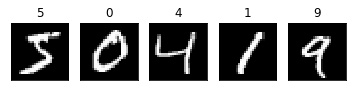

In [7]:
fig, axs = plt.subplots(1, 5)
for i, ax in enumerate(axs):
    ax.imshow(train_loader.dataset.train_data[i], cmap='gray')
    ax.set_title(train_loader.dataset.train_labels[i].item())
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
instance = next(iter(train_loader))
print('Instance Example: ', instance[0].shape, instance[1].shape)

Instance Example:  torch.Size([16, 1, 28, 28]) torch.Size([16])


## Seu trabalho começa aqui:

## 1. Implemente aqui sua primeira rede convolucional  

Sua ConvNet deve ser capaz de classificar as imagens do MNIST. Lembre-se que as imagens do MNIST tem apenas 1 canal, isto é, elas são em escala de cinza (e não RBG!).

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=3136, out_features=10)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], 64*7*7) # Ou x = x.view(x.shape[0], -1)
        out = self.fc(x)
        return out

### 1.1 Verifique se a saída do seu modelo está correta

In [10]:
model = ConvNet().to(device)
dummy_pred = check_input(model, device)

Passed


### 1.2 Treine seu modelo por uma ou mais épocas. 

Você deve conseguir ~99% de acurácia na terceira época. 

In [11]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))


* * * Training * * *
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301813
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.008383
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.137078
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.081720
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.028000
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.021742
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.018145
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.000749

* * * Evaluating * * *
Test set: Average loss: 0.0029, Accuracy: 9852/10000 (98.52%)


* * * Training * * *
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.007783
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.233236
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.005254
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.001548
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.016889
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.007922
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.077646
Train Epoch: 2 [56000/60000 (93%)]	Loss: 0.001384

* * * Evaluating * * *
Test set: Average loss: 0.0022, Accuracy: 9887/10000 (98.

## 2. Atualize sua rede convolucional para usar o container nn.Sequential()

A arquitetura da rede pode ser exatamente igual à rede anterior, porém, agora use o nn.Sequential para criar as camadas.

In [19]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, input):
        return input.view(input.size(0), -1)

class ConvNetSeq(nn.Module):
    def __init__(self):
        super(ConvNetSeq, self).__init__()

        self.seq = nn.Sequential(*[
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),
            Flatten(),
            nn.Linear(in_features = 3136, out_features = 10)
        ])
        
    def forward(self, x):   
        out = self.seq(x)
        return out

In [20]:
model = ConvNetSeq().to(device)
dummy_pred = check_input(model, device)

Passed


In [21]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))


* * * Training * * *
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.344187
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.011054
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.001904
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.001668
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.026790
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.033658
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.078309
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.007458

* * * Evaluating * * *
Test set: Average loss: 0.0027, Accuracy: 9863/10000 (98.63%)


* * * Training * * *
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.144584
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.025954
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.001706
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.001082
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.004851
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.000145
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.340389
Train Epoch: 2 [56000/60000 (93%)]	Loss: 0.041642

* * * Evaluating * * *
Test set: Average loss: 0.0020, Accuracy: 9906/10000 (99.

## 3. Crie uma nova rede substituindo as camadas de convolução da sua rede anterior por blocos Inception.  

Detalhes:

1. Crie um novo módulo (classe que herda do nn.Module) chamado de InceptionModule. 
2. Nesse módulo você deverá criar camadas convolucionais com filtros 1x1, 3x3 e 5x5 paralelamente. No final, concatene o resultado, e aplique mais uma convolução 1x1 para reduzir a dimensionalidade ao tamanho original. 
2. Atualize sua rede convolucional substituindo as camadas de convolução pelo seu bloco Inception. 
3. Treine o modelo e reporte a acurácia. 

In [50]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, padding = 0)
        self.conv_2 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.conv_3 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 5, padding = 2)
        self.conv_4 = nn.Conv2d(in_channels = 3*out_channels, out_channels = out_channels, kernel_size = 1, padding = 0)
        
    def forward(self, x):
        a = self.conv_1(x)
        b = self.conv_2(x)
        c = self.conv_3(x)

        concat = torch.cat((a, b, c), 1)
        out = self.conv_4(concat)
        return out

In [51]:
class InceptionNet(nn.Module):
    def __init__(self,):
        super(InceptionNet, self).__init__()  
        
        self.seq = nn.Sequential(*[
            InceptionModule(1, 32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),
            InceptionModule(32, 64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),
            Flatten(),
            nn.Linear(in_features = 3136, out_features = 10)
        ])

    def forward(self, x):
        out = self.seq(x)
        return out

In [52]:
model = InceptionNet().to(device)
dummy_pred = check_input(model, device)

Passed


In [53]:
acc = train(model, train_loader, test_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))


* * * Training * * *
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309917
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.064380
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.830235
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.337451
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.009634
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.006171
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.157556
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.202445

* * * Evaluating * * *
Test set: Average loss: 0.0028, Accuracy: 9865/10000 (98.65%)


* * * Training * * *
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.002487
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.019056
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.000087
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.002717
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.038038
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.001036
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.004671
Train Epoch: 2 [56000/60000 (93%)]	Loss: 0.001712

* * * Evaluating * * *
Test set: Average loss: 0.0028, Accuracy: 9856/10000 (98.